## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import datetime
from collections import defaultdict
import requests
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()
pd.set_option('display.max_columns', 100)

## Load Dataset And Data Profiling

In [2]:
url = "https://raw.githubusercontent.com/indrasetiadhip/data-task-sample/main/data-sample.json"
response = requests.get(url)
data = response.json()
df = pd.json_normalize(data)

In [3]:
df.head()

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,UserVar.branch_dest,UserVar.taskStatusLabel,UserVar.receiver_city,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus
0,2022-11-01 20:17:26 +0700,pacifiedLion0,2022-11-01 20:46:30 +0700,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,SRG,Success,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,13,CGK,COLF01
1,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 12:33:48 +0700,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,1.3,CGK,COLF01
2,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 13:41:57 +0700,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01
3,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 18:18:19 +0700,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,0.625,CGK,COLF01
4,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 10:51:49 +0700,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,MGL,Success,"BAGELEN,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01


In [4]:
# Dataframe dimension
print("Dataframe dimension    :",df.shape)
print("Dataframe size         :",df.size)
print("Number of Row          :",len(df.index))
print("Number of Columns      :",len(df.columns))

Dataframe dimension    : (8334, 18)
Dataframe size         : 150012
Number of Row          : 8334
Number of Columns      : 18


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8334 entries, 0 to 8333
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   taskCreatedTime                8334 non-null   object 
 1   taskAssignedTo                 8333 non-null   object 
 2   taskCompletedTime              7566 non-null   object 
 3   taskStatus                     8334 non-null   object 
 4   flow                           8334 non-null   object 
 5   taskId                         8334 non-null   object 
 6   taskLocationDone.lon           7566 non-null   float64
 7   taskLocationDone.lat           7566 non-null   float64
 8   cod.amount                     2358 non-null   float64
 9   cod.received                   2358 non-null   object 
 10  UserVar.branch_dest            8334 non-null   object 
 11  UserVar.taskStatusLabel        7572 non-null   object 
 12  UserVar.receiver_city          8282 non-null   o

In [6]:
df.describe()

,taskLocationDone.lon,taskLocationDone.lat,cod.amount
count,7566.000000,7566.000000,2.358000e+03
mean,75.355852,-3.610514,1.911411e+05
std,52.492016,3.647171,2.723770e+05
min,0.000000,-10.493658,8.370000e+02
25%,0.000000,-7.061575,6.100000e+04
50%,106.843097,-3.329263,1.533750e+05
75%,112.182877,0.000000,2.350000e+05
max,140.806424,5.564040,4.730000e+06


### Check Null Values

In [7]:
# number of null values
num_null = df.isnull().sum()

# percentage null values
pct_null = round((num_null/df.shape[0] * 100), 2)

# Create dataframe for number of null value and percentage of null values
df_null = pd.DataFrame({
    'Null Values':num_null,
    'Percentage':pct_null}).reset_index()

# Rename column index to Feature 
df_null.rename(columns={'index':'Features'}, inplace=True)

# Filter only features with null values and sort as descending
df_null = df_null[df_null['Null Values'] > 0].sort_values('Null Values', ascending=False).reset_index(drop=True)
df_null

,Features,Null Values,Percentage
0,cod.amount,5976,71.71
1,cod.received,5976,71.71
2,taskCompletedTime,768,9.22
3,taskLocationDone.lon,768,9.22
4,taskLocationDone.lat,768,9.22
5,UserVar.taskStatusLabel,762,9.14
6,UserVar.taskDetailStatusLabel,762,9.14
7,UserVar.taskDetailStatus,762,9.14
8,UserVar.taskStatus,762,9.14
9,UserVar.branch_origin,293,3.52


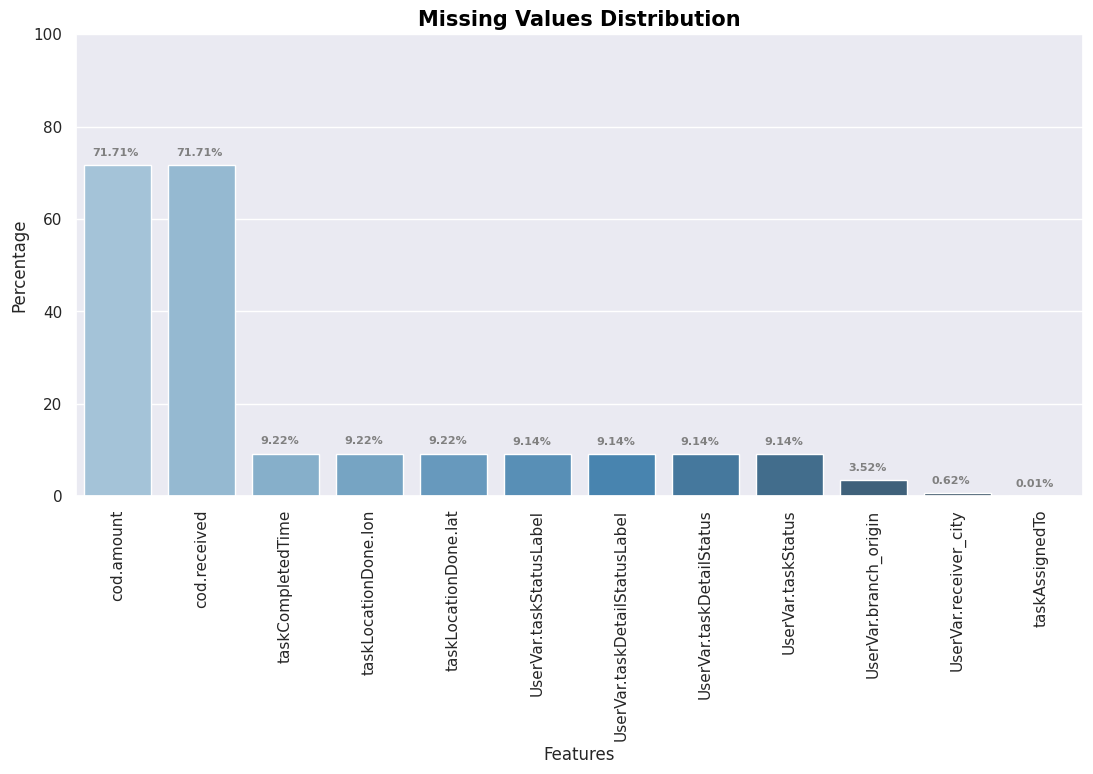

In [8]:
# Plotting number of missing data
fig, ax = plt.subplots(figsize=(13,6))

g = sns.barplot(x = 'Features',y='Percentage',data=df_null,ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

x = np.arange(len(df_null['Features']))
y = df_null['Percentage']

for i, v in enumerate(y):
    ax.text(x[i]-0.3, v+2, str(v)+'%', fontsize = 8, color='gray', fontweight='bold')
    

text = '''
'''
ax.text(0,65,text,horizontalalignment='left',color='black',fontsize=10,fontweight='normal')
ax.set_title('Missing Values Distribution', color='black', fontsize=15, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(0,100)
plt.show()

### Check Duplicated Data

In [9]:
# Check the amount of duplicated data
num_duplicated = df.duplicated().sum()
print(f"Total number of duplicate values : {num_duplicated}")

Total number of duplicate values : 0


## Data Cleaning

### Data Type Transformation
Pad tahap ini kita akan melakukan transformasi tipe data setiap kolom sesuai dengan semestinya. 

In [10]:
df['taskCreatedTime'] = pd.to_datetime(df['taskCreatedTime'], utc=True)
df['taskCompletedTime'] = pd.to_datetime(df['taskCompletedTime'], utc=True)

df['taskCreatedTime'] = df['taskCreatedTime'].dt.tz_convert('Asia/Jakarta')
df['taskCompletedTime'] = df['taskCompletedTime'].dt.tz_convert('Asia/Jakarta')

df['UserVar.weight'] = pd.to_numeric(df['UserVar.weight'], errors='coerce')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8334 entries, 0 to 8333
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype                       
---  ------                         --------------  -----                       
 0   taskCreatedTime                8334 non-null   datetime64[ns, Asia/Jakarta]
 1   taskAssignedTo                 8333 non-null   object                      
 2   taskCompletedTime              7566 non-null   datetime64[ns, Asia/Jakarta]
 3   taskStatus                     8334 non-null   object                      
 4   flow                           8334 non-null   object                      
 5   taskId                         8334 non-null   object                      
 6   taskLocationDone.lon           7566 non-null   float64                     
 7   taskLocationDone.lat           7566 non-null   float64                     
 8   cod.amount                     2358 non-null   float64                     
 9

### Check Number of Unique Values
Pada tahap ini kita akan melakukan analisis pada feature kategorikal yang hanya mempunyai satu kategori. Jika kondisi tersebut terpenuhi kita akan menghapus feature tersebut karena tidak akan berpengaruh pada model kita nantinya.

In [12]:
cat_col = df.select_dtypes('object').columns
# Create dataframe for number of unique values each categorical feature
df_cat_unique = pd.DataFrame(columns=['Feature', 'unique_values'])

# Repeat for each categorical features
for col in cat_col:
    # number of unique value 
    unique = df[col].nunique()

    # Append number of unique values to dataframe
    df_cat_unique = df_cat_unique.append({
        'Feature':col,
        'unique_values':unique
    }, ignore_index=True).sort_values('unique_values', ascending=False)

df_cat_unique

,Feature,unique_values
0,taskId,8334
1,taskAssignedTo,2787
2,UserVar.receiver_city,1830
3,UserVar.branch_dest,62
4,UserVar.branch_origin,59
5,UserVar.taskDetailStatusLabel,31
6,UserVar.taskDetailStatus,31
7,taskStatus,2
8,cod.received,2
9,UserVar.taskStatusLabel,2


Jika kita lihat dari hasil diatas, kolom **flow** hanya memiliki satu nilai. Maka nantinya kolom tersebut tidak akan kita sertakan dalam pemodelan.

### Check Cardinality
Pada tahap ini kita pastikan kembali bahwa tidak ada feature yang memiliki inconsistent data (khusus feature kategorikal).

In [13]:
# List of categorical features
cat_col = df.select_dtypes(include='object').columns

# Repeat for each categorical features
for col in cat_col:
    # Print unique value
    print(f'\n{col} : ', df[col].unique())


taskAssignedTo :  ['pacifiedLion0' 'peacefulTacos6' 'giddyCockatoo1' ... 'culturedPorpoise0'
 'ferventBoa6' 'murkyThrushe3']

taskStatus :  ['done' 'ongoing']

flow :  ['Delivery']

taskId :  ['4fe3b237c832ca4841a2' '08a4da25256affae8446' '2ff0dc469826158b7684' ...
 '1b136b5a3c60749eb571' 'e92e813c8539080c922e' 'cdb90c597655282306fd']

cod.received :  [True nan False]

UserVar.branch_dest :  ['SRG' 'MGL' 'PWT' 'CLG' 'PDG' 'BTJ' 'DTB' 'SMI' 'PKU' 'BDO' 'BTG' 'JBR'
 'BKS' 'CXP' 'SOC' 'MES' 'TKG' 'JOG' 'MXG' 'PNK' 'CBN' 'TGL' 'DJB' 'BPN'
 'BKI' 'GTO' 'MDN' 'MDC' 'KOE' 'PLM' 'SUB' 'CKR' 'UPG' 'DJJ' 'PLW' 'DPS'
 'AMQ' 'BDJ' 'BOO' 'CGK' 'TTE' 'MJK' 'AMI' 'TGR' 'KDI' 'PGK' 'BTH' 'TSM'
 'TIM' 'KDR' 'SOQ' 'PSR' 'MKQ' 'KRW' 'SMD' 'TRK' 'PBL' 'SDA' 'PKY' 'DPK'
 'TJQ' 'TNJ']

UserVar.taskStatusLabel :  ['Success' nan 'Failed']

UserVar.receiver_city :  ['BATANG ,KAB BATANG' 'PURWODADI,PURWOREJO' 'BAGELEN,PURWOREJO' ...
 'MEDAN KOTA,MEDAN' 'DENDANG,MUARASABAK' 'KOTA BANTUL']

UserVar.taskDetailSta

### Create New Column
Pada tahap ini kita akan membuat beberapa kolom dari kolom yang sudah tersedia. 

In [14]:
df['taskCreatedDate'] = df['taskCreatedTime'].dt.date
df['taskCompletedDate'] = df['taskCompletedTime'].dt.date

df['taskCreatedDate'] = pd.to_datetime(df['taskCreatedDate'])
df['taskCompletedDate'] = pd.to_datetime(df['taskCompletedDate'])

df['taskCreatedHour'] = df['taskCreatedTime'].dt.hour
df['taskCompletedHour'] = df['taskCompletedTime'].dt.hour

df['diff_hours'] = (df['taskCompletedTime'] - df['taskCreatedTime']) / np.timedelta64(1, 'h')

df = pd.concat([df, df['UserVar.receiver_city'].str.split(',', expand=True)], axis=1).rename(columns = {0:'kecamatan', 1:'kota/kab', 2:'provinsi'})

## Exploratory Data Analysis

In [15]:
df.head()

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,UserVar.branch_dest,UserVar.taskStatusLabel,UserVar.receiver_city,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus,taskCreatedDate,taskCompletedDate,taskCreatedHour,taskCompletedHour,diff_hours,kecamatan,kota/kab,provinsi
0,2022-11-01 20:17:26+07:00,pacifiedLion0,2022-11-01 20:46:30+07:00,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,SRG,Success,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,13.000,CGK,COLF01,2022-11-01,2022-11-01,20,20.0,0.484444,BATANG,KAB BATANG,None
1,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 12:33:48+07:00,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,1.300,CGK,COLF01,2022-11-01,2022-11-01,8,12.0,3.878056,PURWODADI,PURWOREJO,None
2,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 13:41:57+07:00,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,2022-11-01,2022-11-01,8,13.0,5.013889,PURWODADI,PURWOREJO,None
3,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 18:18:19+07:00,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,0.625,CGK,COLF01,2022-11-01,2022-11-01,8,18.0,9.620000,PURWODADI,PURWOREJO,None
4,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 10:51:49+07:00,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,MGL,Success,"BAGELEN,PURWOREJO",YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,2022-11-01,2022-11-01,8,10.0,2.178333,BAGELEN,PURWOREJO,None


### Map Plotting

In [16]:
# plotting map using plotly
fig = px.scatter_geo(
    df[(df['taskLocationDone.lat'] != 0) | (df['taskLocationDone.lon'] != 0)], 
    lat = 'taskLocationDone.lat', 
    lon = 'taskLocationDone.lon', 
    color = 'UserVar.branch_dest',
    scope='asia'
    )

# setting title for the map
fig.update_layout(title = 'Persebaran Tujuan Pengiriman Tugas', title_x = 1)

# displaying the map
fig.show()

Pada peta diatas, kita bisa melihat persebaran pengiriman dari berbagai daerah di Indonesia sesuai dengan kode cabang tujuan.

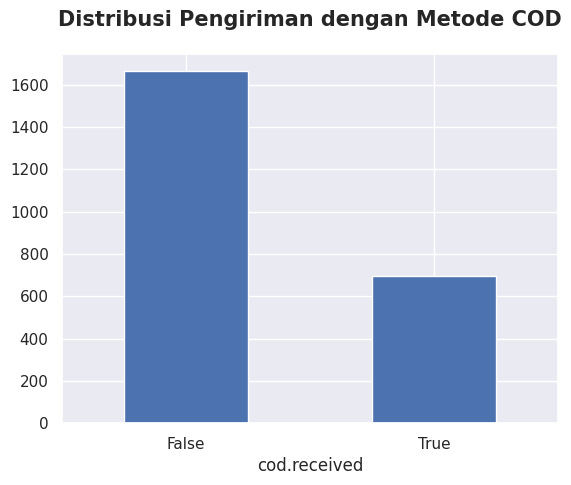

In [17]:
df.groupby('cod.received')['taskId'].nunique().plot(kind='bar')
plt.title('Distribusi Pengiriman dengan Metode COD', fontsize=15, pad=20, fontweight='bold') 
plt.xticks(rotation=0)
plt.show()

Pada grafik diatas, dapat dilihat bahwa sebagian besar pengiriman dengan metode Cash On Delivery (COD) gagal (tidak diterima), dengan lebih dari 1600 pengiriman.

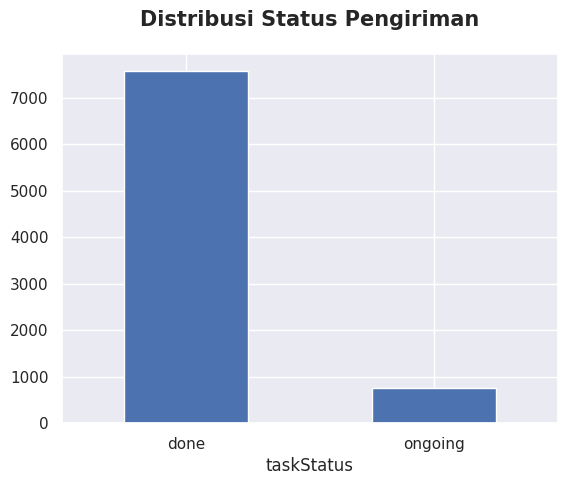

In [18]:
df.groupby('taskStatus')['taskId'].nunique().plot(kind='bar')
plt.title('Distribusi Status Pengiriman', fontsize=15, pad=20, fontweight='bold')
plt.xticks(rotation=0)
plt.show()

UserVar.taskStatusLabel
Failed     2145
Success    5427
Name: taskId, dtype: int64


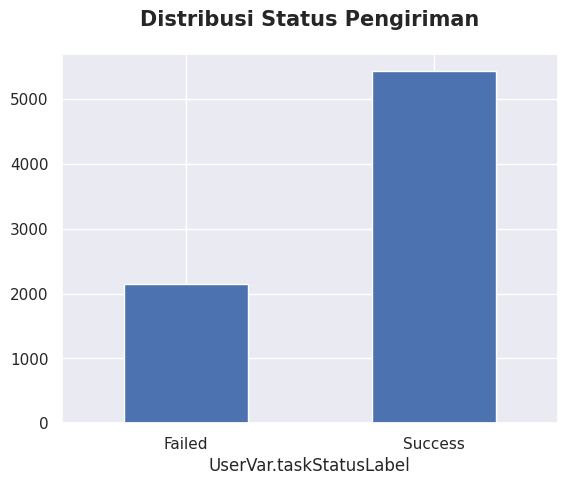

In [19]:
print(df.groupby('UserVar.taskStatusLabel')['taskId'].nunique())
df.groupby('UserVar.taskStatusLabel')['taskId'].nunique().plot(kind='bar')
plt.title('Distribusi Status Pengiriman', fontsize=15, pad=20, fontweight='bold') 
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x600 with 0 Axes>

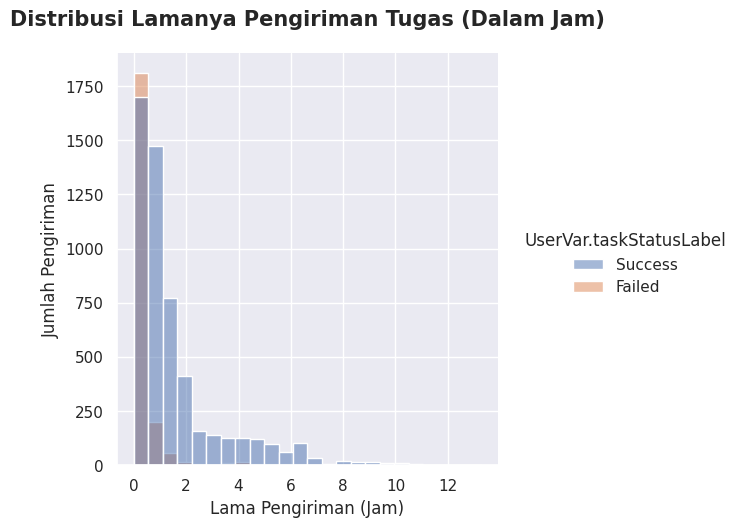

In [20]:
plt.figure(figsize=(12,6))
sns.displot(df, x='diff_hours', hue='UserVar.taskStatusLabel', bins=24)
plt.title('Distribusi Lamanya Pengiriman Tugas (Dalam Jam)', fontsize=15, pad=20, fontweight='bold') 
plt.xlabel('Lama Pengiriman (Jam)')
plt.ylabel('Jumlah Pengiriman')
plt.show()

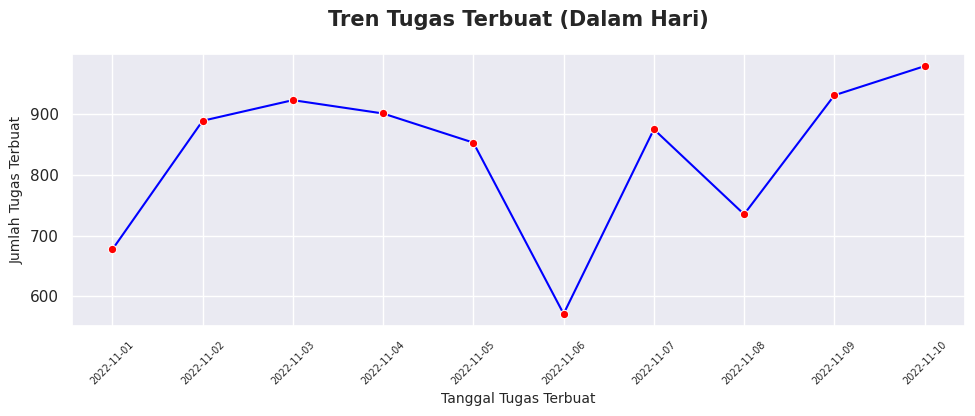

In [21]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df.groupby('taskCreatedDate')['taskId'].nunique().reset_index(), y="taskId", x="taskCreatedDate", marker="o", markerfacecolor='red', color='blue')
plt.title('Tren Tugas Terbuat (Dalam Hari)', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Tanggal Tugas Terbuat', fontsize=10)
plt.ylabel('Jumlah Tugas Terbuat', fontsize=10)
plt.tight_layout()
plt.xticks(rotation=45, fontsize=7)
plt.show()

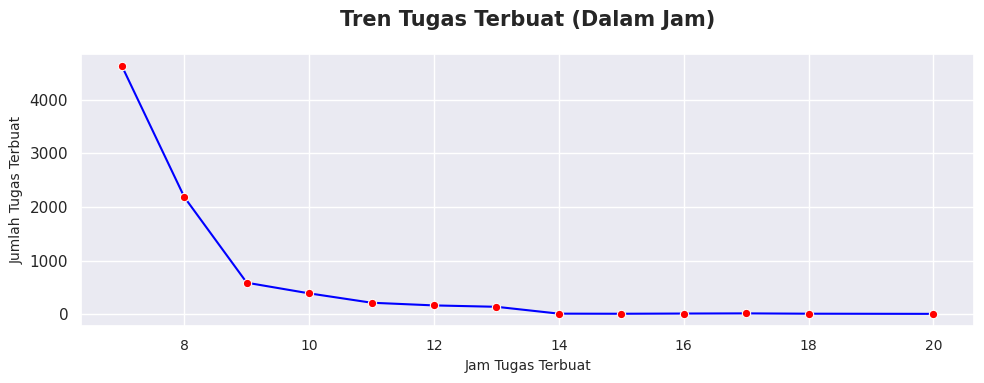

In [22]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df.groupby('taskCreatedHour')['taskId'].nunique().reset_index(), y="taskId", x="taskCreatedHour", marker="o", markerfacecolor='red', color='blue')
plt.title('Tren Tugas Terbuat (Dalam Jam)', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Jam Tugas Terbuat', fontsize=10)
plt.ylabel('Jumlah Tugas Terbuat', fontsize=10)
plt.tight_layout()
plt.xticks(rotation=0, fontsize=10)
plt.show()

In [23]:
df.head()

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,UserVar.branch_dest,UserVar.taskStatusLabel,UserVar.receiver_city,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus,taskCreatedDate,taskCompletedDate,taskCreatedHour,taskCompletedHour,diff_hours,kecamatan,kota/kab,provinsi
0,2022-11-01 20:17:26+07:00,pacifiedLion0,2022-11-01 20:46:30+07:00,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,SRG,Success,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,13.000,CGK,COLF01,2022-11-01,2022-11-01,20,20.0,0.484444,BATANG,KAB BATANG,None
1,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 12:33:48+07:00,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,1.300,CGK,COLF01,2022-11-01,2022-11-01,8,12.0,3.878056,PURWODADI,PURWOREJO,None
2,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 13:41:57+07:00,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,2022-11-01,2022-11-01,8,13.0,5.013889,PURWODADI,PURWOREJO,None
3,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 18:18:19+07:00,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,0.625,CGK,COLF01,2022-11-01,2022-11-01,8,18.0,9.620000,PURWODADI,PURWOREJO,None
4,2022-11-01 08:41:07+07:00,peacefulTacos6,2022-11-01 10:51:49+07:00,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,MGL,Success,"BAGELEN,PURWOREJO",YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,2022-11-01,2022-11-01,8,10.0,2.178333,BAGELEN,PURWOREJO,None


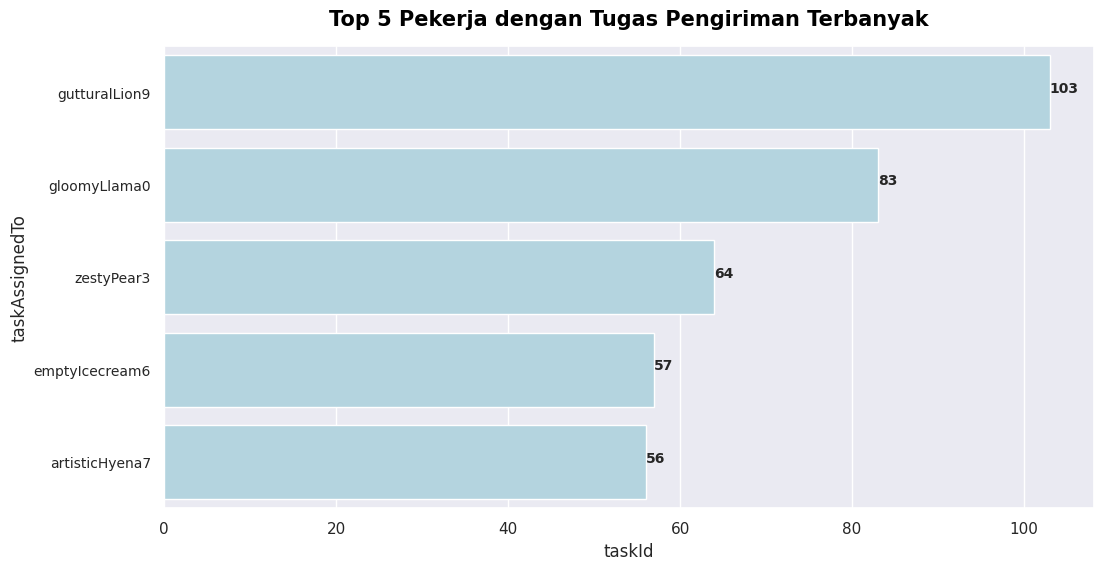

In [24]:
top5_worker_task = df.groupby('taskAssignedTo')['taskId'].nunique().sort_values(ascending=False).reset_index().head()

plt.figure(figsize=(12, 6))
sns.barplot(data=top5_worker_task, x='taskId', y='taskAssignedTo', color='lightblue')

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],i, round(x[i], 4), fontsize=10, fontweight='bold')

x = list(top5_worker_task['taskId'])
y = list(top5_worker_task['taskAssignedTo'])

plt.title('Top 5 Pekerja dengan Tugas Pengiriman Terbanyak', fontsize=15, color='black', pad=15, fontweight='bold')
plt.yticks(fontsize=10)
addlabels(x, y)
plt.show()

## Feature Engineering

### Remove Features
Kita akah menghapus feature yang dirasa tidak terlalu penting. Ada juga yang hanya mempunyai sayu nilai sehingga itu tidak akan berpengaruh pada model yang akan kita buat. 

In [25]:
df.drop(['taskCreatedTime', 'taskAssignedTo', 'taskCompletedTime', 'flow', 'taskId', 'taskLocationDone.lon', 'taskLocationDone.lat', 'taskLocationDone.lon', 'cod.amount', 'cod.received',
'UserVar.branch_dest', 'UserVar.receiver_city', 'UserVar.taskDetailStatusLabel', 'UserVar.taskDetailStatus', 'UserVar.branch_origin', 'UserVar.taskStatus',
'taskCreatedDate', 'taskCompletedDate', 'kecamatan', 'kota/kab', 'provinsi'], axis=1, inplace=True)

### Feature Encoding
Karena tidak semua model machine learning dapat menangani data kategorikal, maka kita akan rubah data kategorikal menjadi numerik. Pada step ini akan melakukan encoding pada beberapa kolom, seperti kolom **taskStatus** dan **UserVar.taskStatusLabel**. Karena dua kolom tersebut hanya memiliki dua nilai unik, kita bisa mengubah menggunakan LabelEncoding ataupun replace kedua nilai tersebut.

In [26]:
df['taskStatus'] = df['taskStatus'].replace({'done': 1, 'ongoing':0})
df['UserVar.taskStatusLabel'] = df['UserVar.taskStatusLabel'].replace({'Success': 1, 'Failed':0})

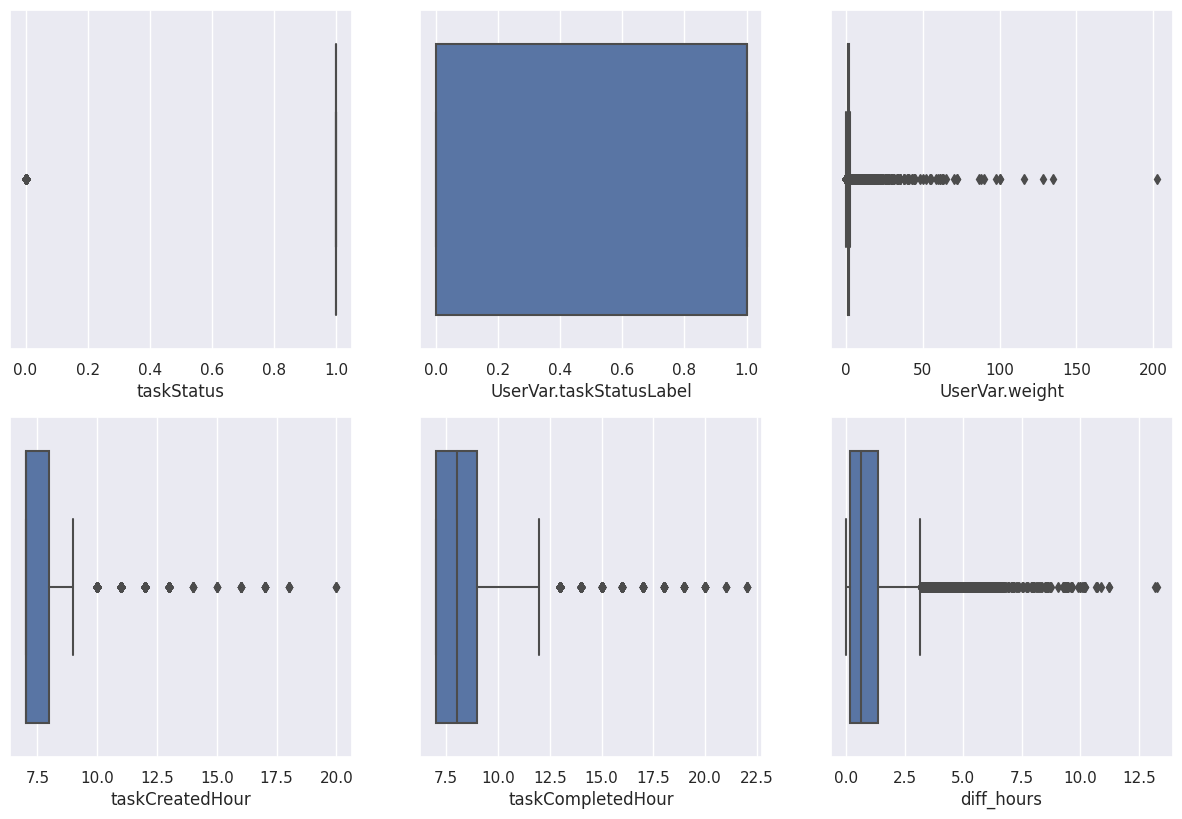

In [27]:
# Plot distribution data using boxplot
num_col = df.select_dtypes('number').columns
plt.figure(figsize=(15, 15))
pos = 1

for i in num_col:
    plt.subplot(3, 3, pos)
    sns.boxplot(data=df, x=i)
    pos += 1

In [28]:
df.head()

,taskStatus,UserVar.taskStatusLabel,UserVar.weight,taskCreatedHour,taskCompletedHour,diff_hours
0,1,1.0,13.000,20,20.0,0.484444
1,1,1.0,1.300,8,12.0,3.878056
2,1,1.0,3.000,8,13.0,5.013889
3,1,1.0,0.625,8,18.0,9.620000
4,1,1.0,3.000,8,10.0,2.178333


Karena pada data kita terdapat nilai outliers, maka lakukan scaling menggunakan RobustScaler.

In [29]:
# Feature scaling using RobustScaler
cols = ['taskStatus', 'UserVar.weight', 'taskCreatedHour', 'taskCompletedHour', 'diff_hours']
df[cols] = RobustScaler().fit_transform(df[cols])

In [30]:
for col in df.columns:
  df[col] = df[col].fillna(df[col].median())

df['UserVar.taskStatusLabel'] = df['UserVar.taskStatusLabel'].astype('int64')

In [31]:
df.head()

,taskStatus,UserVar.taskStatusLabel,UserVar.weight,taskCreatedHour,taskCompletedHour,diff_hours
0,0.0,1,20.000000,13.0,6.0,-0.113576
1,0.0,1,0.500000,1.0,2.0,2.709532
2,0.0,1,3.333333,1.0,2.5,3.654419
3,0.0,1,-0.625000,1.0,5.0,7.486193
4,0.0,1,3.333333,1.0,1.0,1.295552


## Sampling Dataset

### Separating Train and Test Set

In [32]:
# Separate feature and target
X = df.drop('UserVar.taskStatusLabel', axis=1)
y = df['UserVar.taskStatusLabel']

In [33]:
# Separate train and test set for modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and test set dimension
print('Shape of X_train', X_train.shape)
print('Shape of y_train', y_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (6667, 5)
Shape of y_train (6667,)
Shape of X_test (1667, 5)
Shape of y_test (1667,)


### Oversampling Using SMOTE
Karena pada target yang kita miliki terdapat imbalanced class, maka kita akan melakukan oversampling menggunakan metode SMOTE. Oversampling hanya dilakukan pada data training.

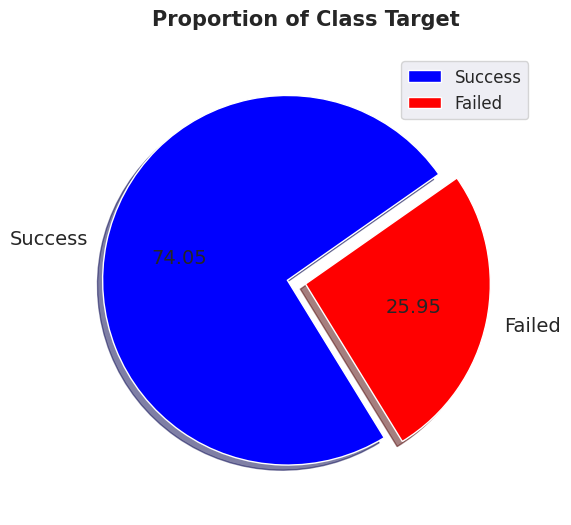

In [34]:
# Distribution of training target
plt.figure(figsize=(6,6))
plt.pie(
        y_train.value_counts(),
        autopct='%.2f',
        explode=[0.1,0],
        labels=["Success","Failed"], 
        shadow=True, 
        textprops={'fontsize': 14},
        colors=["blue","red"], 
        startangle=35)

plt.title("Proportion of Class Target",fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc="best")
plt.show()

In [35]:
# oversampling
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)

# distribution target after oversampling
pd.Series(y_train_over).value_counts()

1    4937
0    4937
Name: UserVar.taskStatusLabel, dtype: int64

## Modeling
Pada tahap modelling kita akan membandingkan beberapa metode yang nantinya kita akan pilih mana model yang menghasilkan performa terbaik. Model dengan performa terbaik yang nantinya akan kita pilih dalam tahap selanjutnya.

### Choose the Best Classifier

In [36]:
# Model assignment
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
etc = ExtraTreesClassifier() 
gbc = GradientBoostingClassifier()
bgc = BaggingClassifier()
knn = KNeighborsClassifier() 
logreg = LogisticRegression()
nb = GaussianNB()
svm = SVC()
xgb = XGBClassifier(eval_metric='error')
mlp = MLPClassifier()

# Assign model to a list
models = [dtc, rfc, abc, etc, gbc, bgc, knn, logreg, nb, svm, xgb, mlp]

model_name = []

# Get Classifier names for every model
for name in models:
    names = str(type(name)).split('.')[-1][:-2]
    # Append classifier names to model_name list
    model_name.append(names)

#### Cross Validation
Pada tahap ini kita lakukan training pada seluruh data menggunakan cross validation.

In [37]:
# Cross validation for each model 
dtc_score = cross_val_score(models[0], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
rfc_score = cross_val_score(models[1], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
abc_score = cross_val_score(models[2], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
etc_score = cross_val_score(models[3], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gbc_score = cross_val_score(models[4], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
bgc_score = cross_val_score(models[5], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
knn_score = cross_val_score(models[6], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
logreg_score = cross_val_score(models[7], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
nb_score = cross_val_score(models[8], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
svm_score = cross_val_score(models[9], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
xgb_score = cross_val_score(models[10], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
mlp_score = cross_val_score(models[11], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

In [38]:
# List of score per model
cv_result = [
    dtc_score, rfc_score, abc_score, etc_score, gbc_score, bgc_score, 
    knn_score, logreg_score, nb_score, svm_score, xgb_score, mlp_score]

# Create dataframe for score every k-fold
df_cv_result = pd.DataFrame(cv_result, index=model_name)
df_cv_result

,0,1,2,3,4
DecisionTreeClassifier,0.727055,0.773245,0.745051,0.752250,0.823529
RandomForestClassifier,0.803239,0.789442,0.762448,0.776245,0.827131
AdaBoostClassifier,0.862627,0.851230,0.790042,0.857828,0.839736
ExtraTreesClassifier,0.818236,0.794841,0.753449,0.773845,0.825930
GradientBoostingClassifier,0.839832,0.836233,0.793641,0.861428,0.844538
BaggingClassifier,0.770846,0.782843,0.765447,0.762448,0.827131
KNeighborsClassifier,0.824235,0.811038,0.771446,0.823035,0.816327
LogisticRegression,0.865627,0.844631,0.761848,0.848230,0.834934
GaussianNB,0.644871,0.631674,0.509298,0.477504,0.282713
SVC,0.794841,0.850030,0.749850,0.854829,0.836134


In [39]:
# Calculate average for every k-fold validation
cv_mean = []
i = 0
for mean in cv_result:
    mean = cv_result[i].mean()
    cv_mean.append(mean)
    i += 1

In [40]:
# Calculate standard deviation for every k-fold validation
cv_std = []
i = 0 
for std in cv_result:
    std = cv_result[i].std()
    cv_std.append(std)
    i += 1

In [41]:
# Average and standard deviation score for each model
df_cv = pd.DataFrame({'score_mean':cv_mean, 'score_std':cv_std}, index=model_name).sort_values(['score_mean', 'score_std'], ascending=[False, True])
df_cv

,score_mean,score_std
AdaBoostClassifier,0.840293,0.026273
MLPClassifier,0.839693,0.024478
GradientBoostingClassifier,0.835134,0.022471
LogisticRegression,0.831054,0.035998
XGBClassifier,0.819896,0.015138
SVC,0.817137,0.039719
KNeighborsClassifier,0.809216,0.019478
ExtraTreesClassifier,0.793260,0.027039
RandomForestClassifier,0.791701,0.022308
BaggingClassifier,0.781743,0.023740


Pada eksperimen diatas didapatkan nilai rata-rata akurasi dan standard deviasi nya dari setiap k-fold validation. XGBClassifier memiliki performa terbaik dengan rata-rata akurasi mencapai 81.98% dengan standard deviasi 0.015138.

#### Fit and Evaluation
Selain dengan menggunakan Cross Validation, saya juga melakukan uji nilai akurasi pada data training dan testing yang bertujuan untuk melihat akurasi saat data training dan testing dan perbedaaannya. Maka di dapatkan hasil sebagai berikut :



In [42]:
# Create a list to assign a model score
train_score = []
test_score = []

# Create dataframe
df_train_test = pd.DataFrame()
for i in models:
    # Fit each model
    model = i.fit(X_train_over, y_train_over)
    # accuracy for training set
    train_score.append(model.score(X_train_over, y_train_over))
    # accuracy for testing set
    test_score.append(model.score(X_test, y_test))

In [43]:
# Create a dataframe to store accuracy score
df_avg_score = pd.DataFrame({
    'train score':train_score,
    'test score':test_score},
    index=model_name)

# Create a new column for the difference in accuracy score 
df_avg_score['difference'] = abs(df_avg_score['train score'] - df_avg_score['test score'])
# Sort accuracy by smallest difference
df_avg_score = df_avg_score.sort_values(['train score', 'test score','difference'], ascending=[False, False, True])
df_avg_score

,train score,test score,difference
ExtraTreesClassifier,0.994227,0.815837,0.178390
RandomForestClassifier,0.994227,0.815237,0.178990
DecisionTreeClassifier,0.994227,0.798440,0.195787
BaggingClassifier,0.978732,0.806839,0.171893
XGBClassifier,0.908548,0.832034,0.076514
KNeighborsClassifier,0.884140,0.796641,0.087499
GradientBoostingClassifier,0.835224,0.839232,0.004008
AdaBoostClassifier,0.826717,0.838632,0.011916
MLPClassifier,0.807677,0.829634,0.021957
SVC,0.787219,0.772046,0.015173


Pada hasil percobaan antara cross validation dan pelatihan pada data training dan testing, saya simpulkan bahwa model XGBClassifier karena nilai akurasi pada kedua data cukup sedikit perbedaannya dan performanya yang paling stabil.

### XBGClassifier
Pada tahap ini kita akan melakukan perbandingan performa model sebelum dan sesudah dilakukan feature selection.

#### Default Parameter

In [44]:
# Fit classifier
xgb.fit(X_train_over, y_train_over)

# predict test set
y_pred_def = xgb.predict(X_test)

# Calculate accuracy, precision, recall, and f1-score
train_score_def = round((xgb.score(X_train_over, y_train_over) * 100), 2)
test_score_def = round((xgb.score(X_test, y_test) * 100), 2)
prec_score_def = round((precision_score(y_test, y_pred_def)) * 100, 2)
recall_score_def = round((recall_score(y_test, y_pred_def)) * 100, 2)
f1_def = round(f1_score(y_test, y_pred_def)*100, 2)

print('Training Accuracy : {}%'.format(train_score_def))
print('Test Accuracy : {}%'.format(test_score_def))
print('Precision Score : {}%'.format(prec_score_def))
print('Recall Score : {}%'.format(recall_score_def))
print('F1 Score : {}%'.format(f1_def))

Training Accuracy : 90.85%
Test Accuracy : 83.2%
Precision Score : 92.19%
Recall Score : 84.82%
F1 Score : 88.35%


#### Hyperparameter Tuning
Lakukan tuning parameter untuk memilih parameter terbaik yang akan digunakan. Metode tuning yang digunakan yaitu Random Search CV. Random Search CV dipilih karena lebih mudah dan murah pada sisi komputasi.

In [45]:
params = {
    'booster':['gbtree', 'gblinear', 'dart'],
    'eta':[0.1, 0.01, 0.001, 0.0001],
    'gamma':[0.1, 0.01, 0.001, 0.0001],
    'max_depth':range(10, 101, 5),
    'min_child_weight':range(0, 51, 5),
    'tree_method':['gpu_hist', 'auto', 'approx', 'exact', 'hist'],
    'scale_pos_weight':range(0, 31, 3),
    'max_delta_step':range(10, 201, 5),
    'max_leaves':range(0, 51, 5),
    'eval_metric':['logloss', 'error', 'auc'],
    'sampling_method':['gradient_based', 'uniform'],
}

xgb_tuned = RandomizedSearchCV(
    estimator=XGBClassifier(), 
    param_distributions=params, 
    n_iter=100,
    scoring='accuracy', cv=5, 
    n_jobs=-1)

In [46]:
xgb_tuned.fit(X_train_over, y_train_over)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'eval_metric': ['logloss', 'error',
                                                        'auc'],
                                        'gamma': [0.1, 0.01, 0.001, 0.0001],
                                        'max_delta_step': range(10, 201, 5),
                                        'max_depth': range(10, 101, 5),
                                        'max_leaves': range(0, 51, 5),
                                        'min_child_weight': range(0, 51, 5),
                                        'sampling_method': ['gradient_based',
                                                            'uniform'],
                                        'scale_pos_weight': range(0, 31, 3),
                                        'tree_method': ['gpu_hist', 'auto',
                                                        'approx', 'exact',
                                                        'hist']},
                   scoring='accuracy')

In [47]:
# best estimator for xgboost
xgb_tuned.best_estimator_

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric='auc',
              feature_types=None, gamma=0.01, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=185, max_depth=25,
              max_leaves=35, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [48]:
# Predict test set
y_pred_tuned = xgb_tuned.predict(X_test)

#Calculate accuracy, precision, recall, and f1-score
train_score_tuned = round((xgb_tuned.score(X_train_over, y_train_over) * 100), 2)
test_score_tuned = round((xgb_tuned.score(X_test, y_test) * 100), 2)
prec_score_tuned = round((precision_score(y_test, y_pred_tuned)) * 100, 2)
recall_score_tuned = round((recall_score(y_test, y_pred_tuned)) * 100, 2)
f1_tuned = round(f1_score(y_test, y_pred_tuned)*100, 2)

print('Training Accuracy : {}%'.format(train_score_tuned))
print('Test Accuracy : {}%'.format(test_score_tuned))
print('Precision Score : {}%'.format(prec_score_tuned))
print('Recall Score : {}%'.format(recall_score_tuned))
print('F1 Score : {}%'.format(f1_tuned))

Training Accuracy : 85.45%
Test Accuracy : 85.9%
Precision Score : 88.85%
Recall Score : 92.89%
F1 Score : 90.82%


In [49]:
pd.DataFrame({
    'train_acc':[train_score_def, train_score_tuned],
    'test_acc':[test_score_def, test_score_tuned],
    'precision':[prec_score_def, prec_score_tuned],
    'recall':[recall_score_def, recall_score_tuned],
    'f1-score':[f1_def, f1_tuned]}, index=['xgb_rfe', 'xgb_rfe_tuned'])

,train_acc,test_acc,precision,recall,f1-score
xgb_rfe,90.85,83.2,92.19,84.82,88.35
xgb_rfe_tuned,85.45,85.9,88.85,92.89,90.82


Setelah dilakukan hyperparameter tuning, ternyata model mengalami kenaikan nilai akurasi pada data training, tetapi memgalami penurunan pada data testing. Ini mengindikasikan bahwa model overfitting dengan perbedaan nilai akurasi sekitar 16% setelah hyperparameter tuning. Karena secara keseluruhan model mengalami penurunan performa, maka kita akan menggunakan default parameter.

## Model Evaluation
Lakukan evaluasi terhadap model, seperti melihat confusion matrix, classification report dan feature importance hasil training.

### Confusion Matrix

[[ 325   90]
 [ 190 1062]]


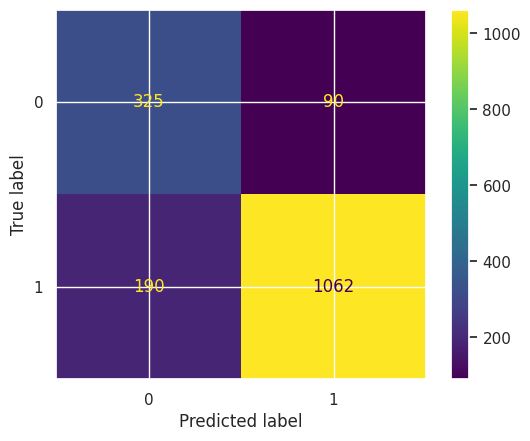

In [50]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_def)
print(cm)
ConfusionMatrixDisplay(cm).plot()
plt.show()

### Classification Report

In [51]:
# Classification report model
cr = classification_report(y_test, y_pred_def)
print(cr)

              precision    recall  f1-score   support

           0       0.63      0.78      0.70       415
           1       0.92      0.85      0.88      1252

    accuracy                           0.83      1667
   macro avg       0.78      0.82      0.79      1667
weighted avg       0.85      0.83      0.84      1667



### Feature Importance

In [52]:
feature_importance = pd.DataFrame({
    'Features':X.columns,
    'Importance':xgb.feature_importances_}).sort_values('Importance', ascending=False)

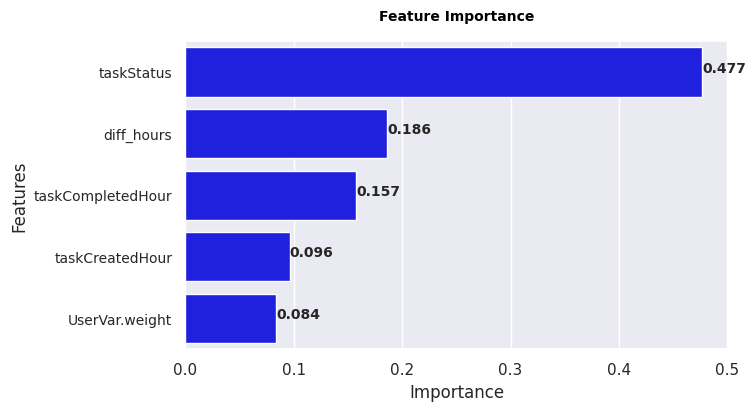

In [57]:
plt.figure(figsize=(7, 4))
sns.barplot(data=feature_importance, x='Importance', y='Features', color='blue')

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],i, round(x[i], 3), fontsize=10, fontweight='bold')

x = list(feature_importance['Importance'])
y = list(feature_importance['Features'])

plt.title('Feature Importance', fontsize=10, color='black', pad=15, fontweight='bold')
plt.yticks(fontsize=10)
addlabels(x, y)
plt.show()

Dari hasil diatas, fitur taskStatus memiliki nilai yang cukup tinggi dari semua fitur yang digunakan dalam pemodelan.